In [1]:
from PIL import Image
import numpy as np
import torch
from torchvision import models, transforms
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Copied from Manning's "Interpretable AI" book
# Code below adapted from: https://github.com/utkuozbulak/pytorch-cnn-visualizations
 
class CamExtractor():
    """
        Extracts cam features from the model
    """
    def __init__(self, model, features, fc, fc_layer, target_layer):
        self.model = model
        self.features = features
        self.fc = fc
        self.fc_layer = fc_layer
        self.target_layer = target_layer
        self.gradients = None
 
    def save_gradient(self, grad):
        self.gradients = grad
 
    def forward_pass_on_convolutions(self, x):
        """
            Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output = None
        for module_pos, module in self.features._modules.items():
            if module_pos == self.fc_layer:
                break
            x = module(x)
            if module_pos == self.target_layer:
                x.register_hook(self.save_gradient)
                conv_output = x
        return conv_output, x
 
    def forward_pass(self, x):
        """
            Does a full forward pass on the model
        """
        # Forward pass on the convolutions
        conv_output, x = self.forward_pass_on_convolutions(x)
        x = x.view(x.size(0), -1)
        # Forward pass on the classifier
        x = self.fc(x)
        return conv_output, x

In [3]:
# Copied from Manning's "Interpretable AI" book
# Code below adapted from: https://github.com/utkuozbulak/pytorch-cnn-visualizations
 
class GradCam():
    """
        Produces class activation map
    """
    def __init__(self, model, features, fc, fc_layer, target_layer):
        self.model = model
        self.features = features
        self.fc = fc
        self.fc_layer = fc_layer
        self.model.eval()
        self.extractor = CamExtractor(self.model,
                                      self.features,
                                      self.fc,
                                      self.fc_layer,
                                      target_layer)
 
    def generate_cam(self, input_image, target_class=None):
        conv_output, model_output = self.extractor.forward_pass(input_image)
        if target_class is None:
            target_class = np.argmax(model_output.data.numpy())
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        
        self.features.zero_grad()
        self.fc.zero_grad()
        
        model_output.backward(gradient=one_hot_output, retain_graph=True)
        
        guided_gradients = self.extractor.gradients.data.numpy()[0]
        
        target = conv_output.data.numpy()[0]
        weights = np.mean(guided_gradients, axis=(1, 2))
        cam = np.ones(target.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * target[i, :, :]
        cam = np.maximum(cam, 0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))
        cam = np.uint8(cam * 255)
        cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2],
                       input_image.shape[3]), Image.ANTIALIAS))/255
        return cam

In [4]:
MY_PATH='/Users/knut/dev/deep_learning_collection'
PREFIX = f'{MY_PATH}/data/salmon_trout'
VALIDATE_PREFIX = f'{PREFIX}/val'
OBJECT_CATEGORIES = ['salmon', 'trout']
MODEL_PATH = f'{MY_PATH}/model/salmon_trout_model_v1.pth'

In [5]:
def get_model():
    classifier = models.resnet18()
    num_features = classifier.fc.in_features
    classifier.fc = torch.nn.Linear(num_features, len(OBJECT_CATEGORIES))
    classifier.load_state_dict(torch.load(MODEL_PATH))
    classifier.eval();
    return classifier

In [6]:
def get_transform():
    transform = transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        )
    return transform

In [7]:
model = get_model()
transform = get_transform()
grad_cam = GradCam(model, 
                   features=model, 
                   fc=model.fc,
                   fc_layer='fc', 
                   target_layer='layer4')

In [8]:

def get_image(image_path):
    image = Image.open(image_path)
    image = image.convert('RGB')
    return image

In [9]:
image = get_image(f'{VALIDATE_PREFIX}/trout/aug_7.jpg')
transformed_image = transform(image)
tensor_image = torch.unsqueeze(transformed_image, 0)
grad_cam.generate_cam(tensor_image)

array([[0.71372549, 0.71372549, 0.71372549, ..., 0.42352941, 0.42352941,
        0.41960784],
       [0.71372549, 0.71372549, 0.71372549, ..., 0.42352941, 0.42352941,
        0.41960784],
       [0.71764706, 0.71764706, 0.71372549, ..., 0.42352941, 0.42745098,
        0.42352941],
       ...,
       [0.29019608, 0.29411765, 0.29803922, ..., 0.15294118, 0.15294118,
        0.15294118],
       [0.28627451, 0.29411765, 0.29803922, ..., 0.15294118, 0.15294118,
        0.15294118],
       [0.28627451, 0.29019608, 0.29411765, ..., 0.15294118, 0.15294118,
        0.15294118]])

In [10]:
def show_image(image_path, caption=''):
    image = get_image(image_path)
    transformed_image = transform(image)
    tensor_image = torch.unsqueeze(transformed_image, 0)
    cam = grad_cam.generate_cam(tensor_image)
    rows = 1
    columns = 2
    figure = plt.figure(figsize=(128,128))
    i = 0
    i += 1
    figure.add_subplot(rows, columns, i)
    plt.imshow(image)
    i += 1
    figure.add_subplot(rows, columns, i)
    plt.imshow(cam)
    plt.show()

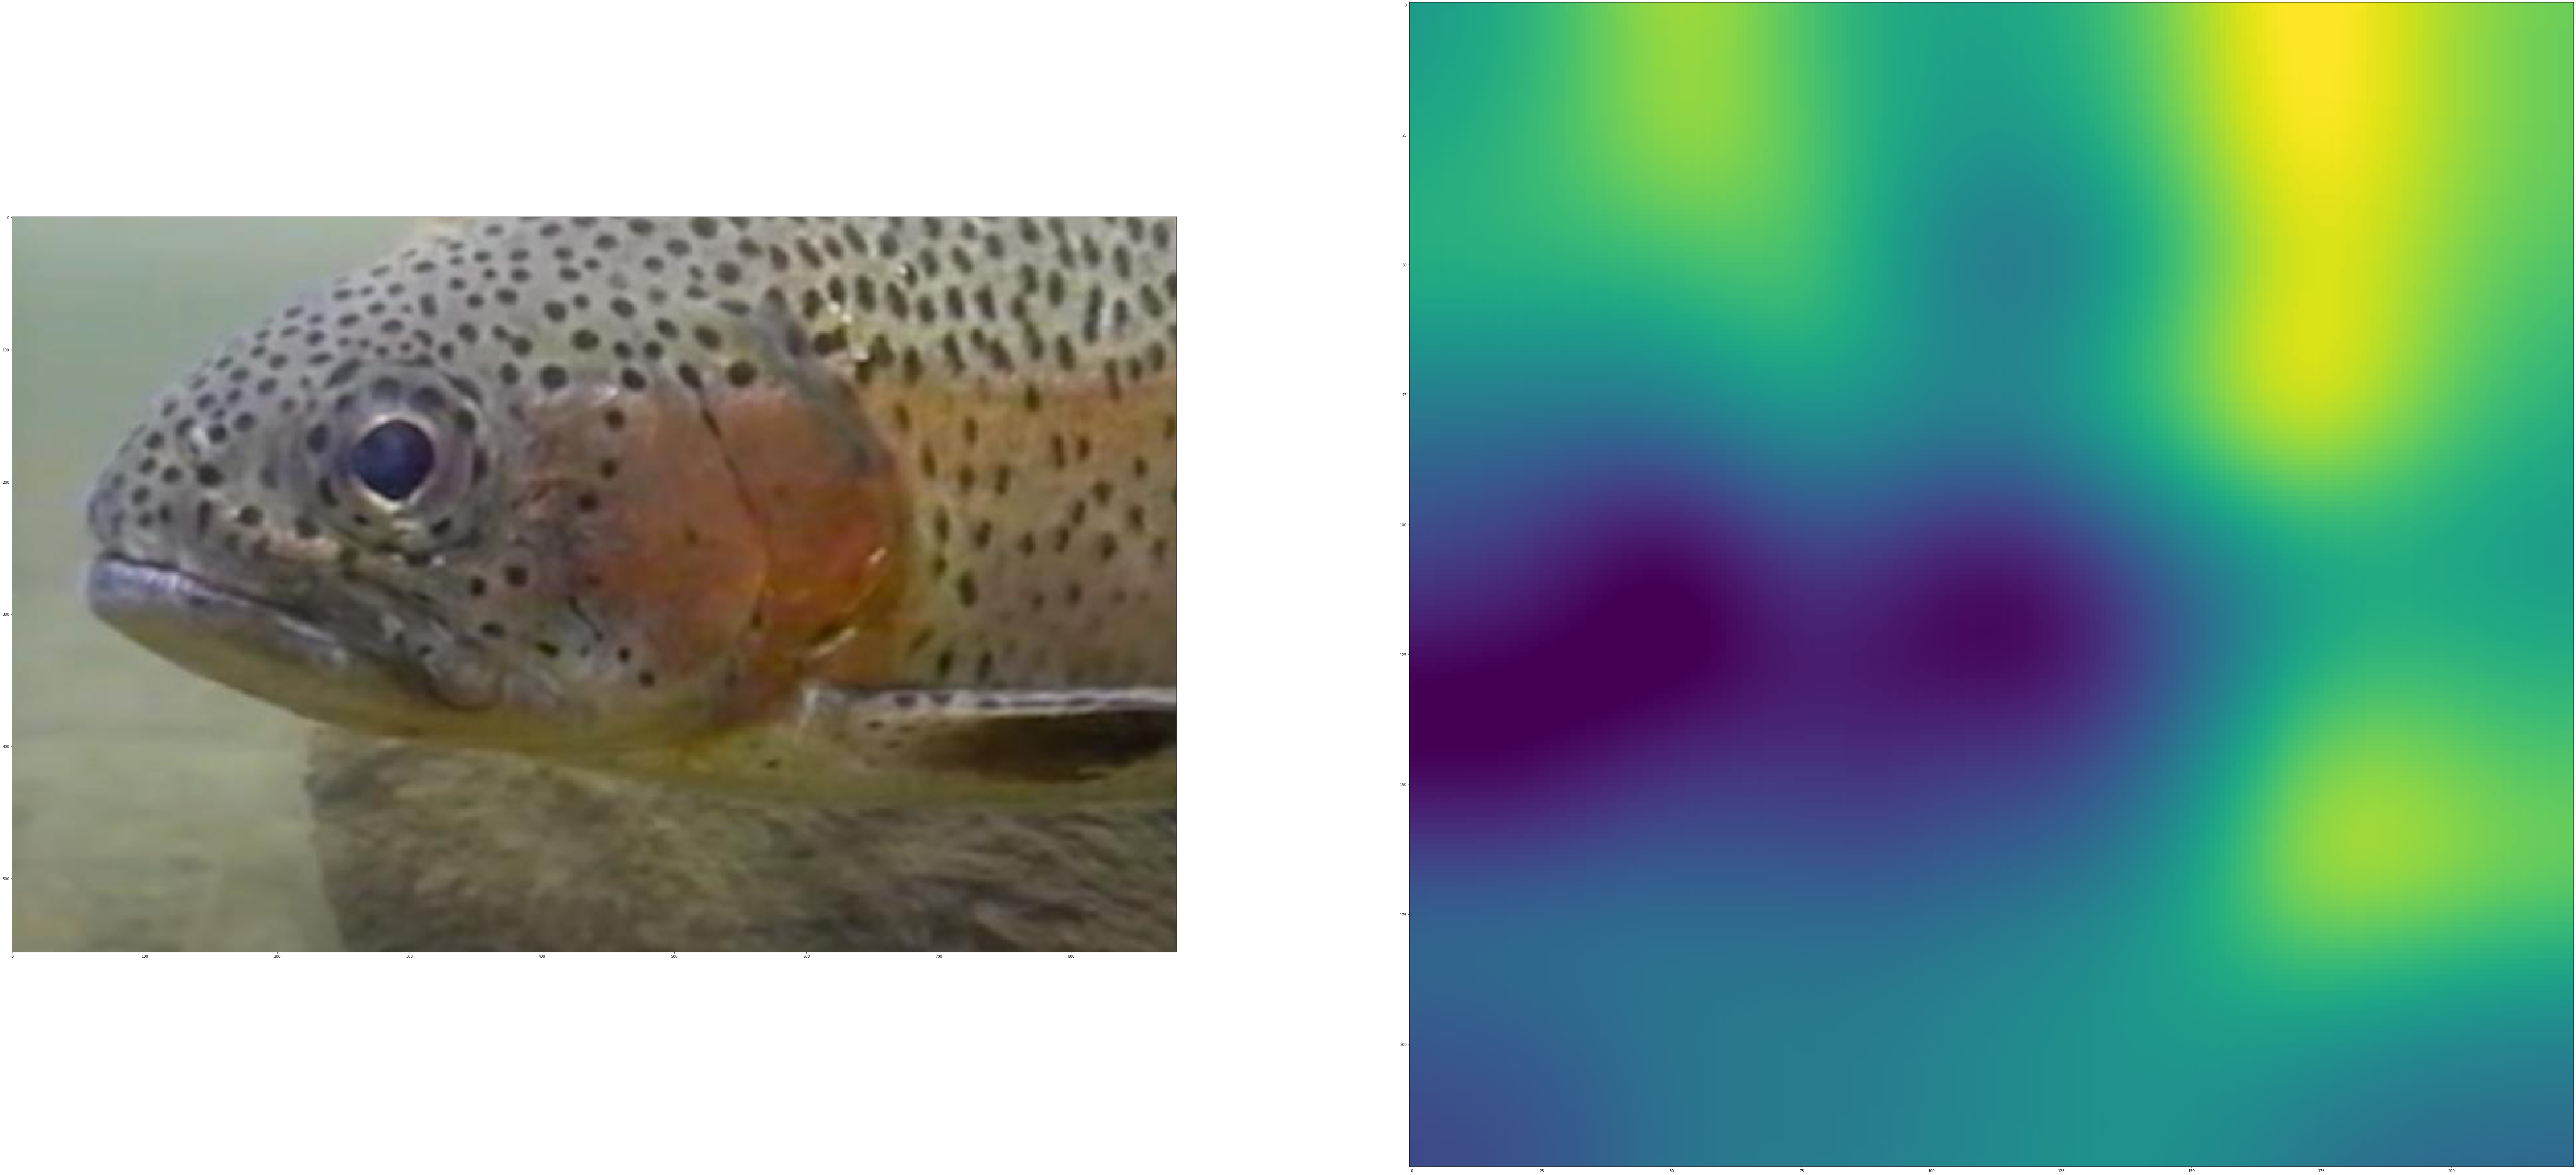

In [11]:
show_image(f'{VALIDATE_PREFIX}/trout/aug_16.jpg')